In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [84]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [85]:
from sklearn.metrics import mean_squared_error

In [86]:
train_df = pd.read_csv('../data/TRAIN.csv')
test_df = pd.read_csv('../data/TEST_FINAL.csv')
sam_sub_df = pd.read_csv('../data/SAMPLE.csv')

In [87]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

train_df['Discount'] = train_df['Discount'].map({'Yes': 1, 'No': 0})
test_df['Discount'] = test_df['Discount'].map({'Yes': 1, 'No': 0})

train_df['Sales'] = np.log(train_df['Sales'].replace(0,1))
train_df['#Order'] = np.log(train_df['#Order'].replace(0,1))

In [88]:
train_df.shape, test_df.shape, sam_sub_df.shape

((188340, 10), (22265, 8), (22265, 2))

In [89]:
train_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,2.197225,8.855355
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,4.094345,10.854935
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,3.737670,10.515105
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,3.135494,9.889143
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,4.127134,10.727981


In [90]:
all_df = train_df.append(test_df).reset_index(drop=True)

In [91]:
all_df.shape

(210605, 10)

In [92]:
all_df.sort_values(['Store_id', 'Date'], inplace=True)

### Calander and Holiday features

In [93]:
holiday_df = train_df[['Date', 'Holiday']].drop_duplicates().reset_index(drop=True)
holiday_df = holiday_df.append(test_df[['Date', 'Holiday']].drop_duplicates().reset_index(drop=True))
holiday_df.sort_values(['Date'], inplace=True)
holiday_df.reset_index(drop=True, inplace=True)

In [94]:
print(holiday_df.shape)
holiday_df.head()

(577, 2)


,Date,Holiday
0,2018-01-01,1
1,2018-01-02,0
2,2018-01-03,0
3,2018-01-04,0
4,2018-01-05,0


In [95]:
holiday_df['YM'] = pd.to_datetime(holiday_df['Date'].dt.year.astype(str) + "-" + holiday_df['Date'].dt.month.astype(str))
holiday_df['Year'] = holiday_df['Date'].dt.year
holiday_df['Month'] = holiday_df['Date'].dt.month
holiday_df['Day'] = holiday_df['Date'].dt.day
holiday_df['DayOfWeek'] = holiday_df['Date'].dt.dayofweek
holiday_df['WeekOfYear'] = holiday_df['Date'].dt.weekofyear
holiday_df['Quarter'] = holiday_df['Date'].dt.quarter

In [96]:
x = holiday_df.groupby(['YM'])[['Holiday']].sum()
x.columns = ['holidays_in_month']
x = x.reset_index()
holiday_df = pd.merge(holiday_df, x, on='YM', how='left')

In [97]:
def get_next_holidays_in_days(x):
    t = holiday_df[(holiday_df['Date'] > x) & (holiday_df['Holiday'] == 1)]
    if t.shape[0] == 0:
        return -1
    else:
        return (t.iloc[0]['Date'] - x).days

In [98]:
def get_previous_holidays_in_days(x):
    t = holiday_df[(holiday_df['Date'] < x) & (holiday_df['Holiday'] == 1)]
    if t.shape[0] == 0:
        return -1
    else:
        return (x - t.iloc[-1]['Date']).days

In [99]:
holiday_df['days_in_next_holiday'] = holiday_df['Date'].apply(lambda x: get_next_holidays_in_days(x))
holiday_df['days_in_previous_holiday'] = holiday_df['Date'].apply(lambda x: get_previous_holidays_in_days(x))

In [100]:
holiday_df.head()

,Date,Holiday,YM,Year,Month,Day,DayOfWeek,WeekOfYear,Quarter,holidays_in_month,days_in_next_holiday,days_in_previous_holiday
0,2018-01-01,1,2018-01-01,2018,1,1,0,1,1,5,13,-1
1,2018-01-02,0,2018-01-01,2018,1,2,1,1,1,5,12,1
2,2018-01-03,0,2018-01-01,2018,1,3,2,1,1,5,11,2
3,2018-01-04,0,2018-01-01,2018,1,4,3,1,1,5,10,3
4,2018-01-05,0,2018-01-01,2018,1,5,4,1,1,5,9,4


### Store ID related region-location type- store type features

In [101]:
stores_df = train_df[['Store_id', 'Region_Code', 'Location_Type', 'Store_Type']].drop_duplicates().reset_index(drop=True)

In [102]:
print(stores_df.shape)
stores_df.head()

(365, 4)


,Store_id,Region_Code,Location_Type,Store_Type
0,1,R1,L3,S1
1,253,R1,L2,S4
2,252,R1,L2,S3
3,251,R1,L3,S2
4,250,R4,L3,S2


In [103]:
x = stores_df.groupby(['Region_Code'])[['Store_id']].count()
x.columns = ['Num_stores_in_region']
x = x.reset_index()
stores_df = pd.merge(stores_df, x, on='Region_Code', how='left')

In [104]:
x = stores_df.groupby(['Region_Code', 'Location_Type'])[['Store_id']].count()
x.columns = ['Num_stores_of_same_loc_type_in_region']
x = x.reset_index()
stores_df = pd.merge(stores_df, x, on=['Region_Code', 'Location_Type'], how='left')

In [105]:
x = stores_df.groupby(['Region_Code', 'Store_Type'])[['Store_id']].count()
x.columns = ['Num_stores_of_same_store_type_in_region']
x = x.reset_index()
stores_df = pd.merge(stores_df, x, on=['Region_Code', 'Store_Type'], how='left')

In [106]:
x = stores_df.groupby(['Region_Code', 'Location_Type', 'Store_Type'])[['Store_id']].count()
x.columns = ['Num_stores_of_same_store_type_in_region_loc']
x = x.reset_index()
stores_df = pd.merge(stores_df, x, on=['Region_Code', 'Location_Type', 'Store_Type'], how='left')

In [107]:
stores_df.head()

,Store_id,Region_Code,Location_Type,Store_Type,Num_stores_in_region,Num_stores_of_same_loc_type_in_region,Num_stores_of_same_store_type_in_region,Num_stores_of_same_store_type_in_region_loc
0,1,R1,L3,S1,124,17,41,13
1,253,R1,L2,S4,124,38,54,33
2,252,R1,L2,S3,124,38,18,4
3,251,R1,L3,S2,124,17,11,1
4,250,R4,L3,S2,50,6,13,5


### Discount related variables for each store-region-location type-store type

In [108]:
all_df['YM'] = pd.to_datetime(all_df['Date'].dt.year.astype(str) + "-" + all_df['Date'].dt.month.astype(str))

In [109]:
x = all_df.groupby(['Region_Code', 'Location_Type', 'Store_Type', 'Date'])[['Discount']].sum()
x.columns = ['num_stores_with_disc_in_same_store_loc_region']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Region_Code', 'Location_Type', 'Store_Type', 'Date'], how='left')

In [110]:
x = all_df.groupby(['Region_Code', 'Location_Type', 'Date'])[['Discount']].sum()
x.columns = ['num_stores_with_disc_in_same_loc_region']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Region_Code', 'Location_Type', 'Date'], how='left')

In [111]:
x = all_df.groupby(['Region_Code', 'Date'])[['Discount']].sum()
x.columns = ['num_stores_with_disc_in_same_region']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Region_Code', 'Date'], how='left')

In [112]:
x = all_df.groupby(['Store_id', 'YM'])[['Discount']].sum()
x.columns = ['discounts_in_month']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Store_id', 'YM'], how='left')

x = all_df.groupby(['Region_Code', 'Location_Type', 'Store_Type', 'YM'])[['Discount']].sum()
x.columns = ['discounts_in_month_same_store_location_region']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Region_Code', 'Location_Type', 'Store_Type', 'YM'], how='left')

x = all_df.groupby(['Region_Code', 'Location_Type', 'YM'])[['Discount']].sum()
x.columns = ['discounts_in_month_same_location_region']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Region_Code', 'Location_Type', 'YM'], how='left')

x = all_df.groupby(['Region_Code', 'YM'])[['Discount']].sum()
x.columns = ['discounts_in_month_same_region']
x = x.reset_index()
all_df = pd.merge(all_df, x, on=['Region_Code', 'YM'], how='left')

In [113]:
all_df['days_in_next_discount'] = all_df['Date']
all_df.loc[all_df['Discount'] == 0, 'days_in_next_discount'] = np.nan
all_df['days_in_next_discount'] = all_df.groupby(['Store_id'])['days_in_next_discount'].shift(-1).fillna(method='bfill')
all_df['days_in_next_discount'] = (all_df['days_in_next_discount'] - all_df['Date']).dt.days
all_df.loc[all_df['days_in_next_discount'] <=0, 'days_in_next_discount'] = -1

In [114]:
all_df['days_in_previous_discount'] = all_df['Date']
all_df.loc[all_df['Discount'] == 0, 'days_in_previous_discount'] = np.nan
all_df['days_in_previous_discount'] = all_df.groupby(['Store_id'])['days_in_previous_discount'].shift(1).fillna(method='ffill')
all_df['days_in_previous_discount'] = (all_df['Date'] - all_df['days_in_previous_discount']).dt.days
all_df.loc[all_df['days_in_previous_discount'] <=0, 'days_in_previous_discount'] = -1

In [115]:
all_df['days_in_next_discount'].fillna(-1, inplace=True)
all_df['days_in_previous_discount'].fillna(-1, inplace=True)

In [116]:
all_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,YM,num_stores_with_disc_in_same_store_loc_region,num_stores_with_disc_in_same_loc_region,num_stores_with_disc_in_same_region,discounts_in_month,discounts_in_month_same_store_location_region,discounts_in_month_same_location_region,discounts_in_month_same_region,days_in_next_discount,days_in_previous_discount
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,2.197225,8.855355,2018-01-01,13,17,124,15,195,255,1858,1.0,-1.0
1,T1000608,1,S1,L3,R1,2018-01-02,0,1,4.094345,10.654172,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0
2,T1001047,1,S1,L3,R1,2018-01-03,0,1,4.276666,10.820518,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0
3,T1001208,1,S1,L3,R1,2018-01-04,0,1,4.158883,10.700927,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0
4,T1001753,1,S1,L3,R1,2018-01-05,0,1,4.143135,10.770672,2018-01-01,13,17,124,15,195,255,1858,8.0,1.0


## Sales and #Orders related time series variables

In [117]:
all_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,YM,num_stores_with_disc_in_same_store_loc_region,num_stores_with_disc_in_same_loc_region,num_stores_with_disc_in_same_region,discounts_in_month,discounts_in_month_same_store_location_region,discounts_in_month_same_location_region,discounts_in_month_same_region,days_in_next_discount,days_in_previous_discount
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,2.197225,8.855355,2018-01-01,13,17,124,15,195,255,1858,1.0,-1.0
1,T1000608,1,S1,L3,R1,2018-01-02,0,1,4.094345,10.654172,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0
2,T1001047,1,S1,L3,R1,2018-01-03,0,1,4.276666,10.820518,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0
3,T1001208,1,S1,L3,R1,2018-01-04,0,1,4.158883,10.700927,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0
4,T1001753,1,S1,L3,R1,2018-01-05,0,1,4.143135,10.770672,2018-01-01,13,17,124,15,195,255,1858,8.0,1.0


In [118]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [119]:
del holiday_df['YM']
del holiday_df['Holiday']
del stores_df['Location_Type']
del stores_df['Region_Code']
del stores_df['Store_Type']

In [120]:
all_df = pd.merge(all_df, holiday_df, on='Date', how='left')
all_df = pd.merge(all_df, stores_df, on='Store_id', how='left')

In [121]:
all_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,YM,num_stores_with_disc_in_same_store_loc_region,num_stores_with_disc_in_same_loc_region,num_stores_with_disc_in_same_region,discounts_in_month,discounts_in_month_same_store_location_region,discounts_in_month_same_location_region,discounts_in_month_same_region,days_in_next_discount,days_in_previous_discount,Year,Month,Day,DayOfWeek,WeekOfYear,Quarter,holidays_in_month,days_in_next_holiday,days_in_previous_holiday,Num_stores_in_region,Num_stores_of_same_loc_type_in_region,Num_stores_of_same_store_type_in_region,Num_stores_of_same_store_type_in_region_loc
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,2.197225,8.855355,2018-01-01,13,17,124,15,195,255,1858,1.0,-1.0,2018,1,1,0,1,1,5,13,-1,124,17,41,13
1,T1000608,1,S1,L3,R1,2018-01-02,0,1,4.094345,10.654172,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0,2018,1,2,1,1,1,5,12,1,124,17,41,13
2,T1001047,1,S1,L3,R1,2018-01-03,0,1,4.276666,10.820518,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0,2018,1,3,2,1,1,5,11,2,124,17,41,13
3,T1001208,1,S1,L3,R1,2018-01-04,0,1,4.158883,10.700927,2018-01-01,13,17,124,15,195,255,1858,1.0,1.0,2018,1,4,3,1,1,5,10,3,124,17,41,13
4,T1001753,1,S1,L3,R1,2018-01-05,0,1,4.143135,10.770672,2018-01-01,13,17,124,15,195,255,1858,8.0,1.0,2018,1,5,4,1,1,5,9,4,124,17,41,13


In [122]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
all_df = create_sales_lag_feats(all_df, gpby_cols=['Store_id'], target_col='Sales', 
                               lags=[61,62,63,64,65,66,67,74,80])

all_df = create_sales_ewm_feats(all_df, gpby_cols=['Store_id'], 
                               target_col='Sales', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[61,62,63,64,65,66,67,74,80])

In [124]:
all_df = create_sales_ewm_feats(all_df, gpby_cols=['Store_id'], 
                               target_col='#Order', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[61,62,63,64,65,66,67,74,80])

In [125]:
all_df.shape

(210605, 150)

In [128]:
all_df.tail()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,YM,num_stores_with_disc_in_same_store_loc_region,num_stores_with_disc_in_same_loc_region,num_stores_with_disc_in_same_region,discounts_in_month,discounts_in_month_same_store_location_region,discounts_in_month_same_location_region,discounts_in_month_same_region,days_in_next_discount,days_in_previous_discount,Year,Month,Day,DayOfWeek,WeekOfYear,Quarter,holidays_in_month,days_in_next_holiday,days_in_previous_holiday,Num_stores_in_region,Num_stores_of_same_loc_type_in_region,Num_stores_of_same_store_type_in_region,Num_stores_of_same_store_type_in_region_loc,Sales_lag_61,Sales_lag_62,Sales_lag_63,Sales_lag_64,Sales_lag_65,Sales_lag_66,Sales_lag_67,Sales_lag_74,Sales_lag_80,Sales_lag_61_ewm_0.95,Sales_lag_62_ewm_0.95,Sales_lag_63_ewm_0.95,Sales_lag_64_ewm_0.95,Sales_lag_65_ewm_0.95,Sales_lag_66_ewm_0.95,Sales_lag_67_ewm_0.95,Sales_lag_74_ewm_0.95,Sales_lag_80_ewm_0.95,Sales_lag_61_ewm_0.9,Sales_lag_62_ewm_0.9,Sales_lag_63_ewm_0.9,Sales_lag_64_ewm_0.9,Sales_lag_65_ewm_0.9,Sales_lag_66_ewm_0.9,Sales_lag_67_ewm_0.9,Sales_lag_74_ewm_0.9,Sales_lag_80_ewm_0.9,Sales_lag_61_ewm_0.8,Sales_lag_62_ewm_0.8,Sales_lag_63_ewm_0.8,Sales_lag_64_ewm_0.8,Sales_lag_65_ewm_0.8,Sales_lag_66_ewm_0.8,Sales_lag_67_ewm_0.8,Sales_lag_74_ewm_0.8,Sales_lag_80_ewm_0.8,Sales_lag_61_ewm_0.7,Sales_lag_62_ewm_0.7,Sales_lag_63_ewm_0.7,Sales_lag_64_ewm_0.7,Sales_lag_65_ewm_0.7,Sales_lag_66_ewm_0.7,Sales_lag_67_ewm_0.7,Sales_lag_74_ewm_0.7,Sales_lag_80_ewm_0.7,Sales_lag_61_ewm_0.6,Sales_lag_62_ewm_0.6,Sales_lag_63_ewm_0.6,Sales_lag_64_ewm_0.6,Sales_lag_65_ewm_0.6,Sales_lag_66_ewm_0.6,Sales_lag_67_ewm_0.6,Sales_lag_74_ewm_0.6,Sales_lag_80_ewm_0.6,Sales_lag_61_ewm_0.5,Sales_lag_62_ewm_0.5,Sales_lag_63_ewm_0.5,Sales_lag_64_ewm_0.5,Sales_lag_65_ewm_0.5,Sales_lag_66_ewm_0.5,Sales_lag_67_ewm_0.5,Sales_lag_74_ewm_0.5,Sales_lag_80_ewm_0.5,#Order_lag_61_ewm_0.95,#Order_lag_62_ewm_0.95,#Order_lag_63_ewm_0.95,#Order_lag_64_ewm_0.95,#Order_lag_65_ewm_0.95,#Order_lag_66_ewm_0.95,#Order_lag_67_ewm_0.95,#Order_lag_74_ewm_0.95,#Order_lag_80_ewm_0.95,#Order_lag_61_ewm_0.9,#Order_lag_62_ewm_0.9,#Order_lag_63_ewm_0.9,#Order_lag_64_ewm_0.9,#Order_lag_65_ewm_0.9,#Order_lag_66_ewm_0.9,#Order_lag_67_ewm_0.9,#Order_lag_74_ewm_0.9,#Order_lag_80_ewm_0.9,#Order_lag_61_ewm_0.8,#Order_lag_62_ewm_0.8,#Order_lag_63_ewm_0.8,#Order_lag_64_ewm_0.8,#Order_lag_65_ewm_0.8,#Order_lag_66_ewm_0.8,#Order_lag_67_ewm_0.8,#Order_lag_74_ewm_0.8,#Order_lag_80_ewm_0.8,#Order_lag_61_ewm_0.7,#Order_lag_62_ewm_0.7,#Order_lag_63_ewm_0.7,#Order_lag_64_ewm_0.7,#Order_lag_65_ewm_0.7,#Order_lag_66_ewm_0.7,#Order_lag_67_ewm_0.7,#Order_lag_74_ewm_0.7,#Order_lag_80_ewm_0.7,#Order_lag_61_ewm_0.6,#Order_lag_62_ewm_0.6,#Order_lag_63_ewm_0.6,#Order_lag_64_ewm_0.6,#Order_lag_65_ewm_0.6,#Order_lag_66_ewm_0.6,#Order_lag_67_ewm_0.6,#Order_lag_74_ewm_0.6,#Order_lag_80_ewm_0.6,#Order_lag_61_ewm_0.5,#Order_lag_62_ewm_0.5,#Order_lag_63_ewm_0.5,#Order_lag_64_ewm_0.5,#Order_lag_65_ewm_0.5,#Order_lag_66_ewm_0.5,#Order_lag_67_ewm_0.5,#Order_lag_74_ewm_0.5,#Order_lag_80_ewm_0.5
210600,T1209045,365,S2,L1,R2,2019-07-27,0,0,NaN,NaN,2019-07-01,0,15,29,12,40,654,1415,-1.0,2.0,2019,7,27,5,30,3,1,-1,23,105,48,20,3,11.901274,11.375013,9.688825,9.685376,9.115956,6.830377,8.212387,9.965997,10.908348,10.602530,10.717869,10.609448,10.556443,10.054427,10.517924,10.395139,10.583731,10.440260,10.607978,10.711644,10.604254,10.532402,10.078228,10.511988,10.400398,10.585095,10.443751,10.616461,10.696465,10.588022,10.491159,10.124333,10.501539,10.410146,10.587344,10.451197,10.620427,10.676351,10.566158,10.458641,10.168784,10.492538,10.418226,10.587740,10.460865,10.618115,10.650598,10.541133,10.434475,10.211891,10.484678,10.425116,10.585080,10.475642,10.607978,10.619495,10.515415,10.418593,10.254320,10.478608,10.432829,10.578700,10.498536,4.009846,4.057581,4.003212,3.924912,3.424599,3.869237,3.831919,3.952417,3.874343,4.012007,4.054068,3.996690,3.900903,3.447839,3.867612,3.83531

## Model Data

In [151]:
all_df['data_type'] = np.nan
all_df.loc[all_df['Date'] >= '2019-06-01', 'data_type'] = 'test'
all_df.loc[(all_df['YM'] == '2019-05-01') | (all_df['YM'] == '2018-07-01'), 'data_type'] = 'valid'
all_df['data_type'] = all_df['data_type'].fillna('train')

In [152]:
all_df['data_type'].value_counts()

train    165710
valid     22630
test      22265
Name: data_type, dtype: int64

In [153]:
trn_df = all_df[all_df['data_type'] == 'train']
val_df = all_df[all_df['data_type'] == 'valid']
test_df = all_df[all_df['data_type'] == 'test']

In [154]:
avoid_cols = ['ID','Date','#Order', 'Sales', 'YM', 'data_type']
feats = [c for c in trn_df.columns if c not in avoid_cols]
target = 'Sales'

In [155]:
len(feats)

145

In [156]:
cat_cols = ['Store_id',
 'Store_Type',
 'Location_Type',
 'Region_Code',
 'Month',
 'Day',
 'DayOfWeek',
 'Quarter',    
    ]

In [157]:
cat_inds = [i for i,c in enumerate(feats) if c in cat_cols]

In [140]:
import catboost as cb

In [158]:
val_pool = cb.Pool(val_df[feats].values, val_df[target], cat_features=cat_inds)

In [159]:
cat_rg1 = cb.CatBoostRegressor(iterations=3000, learning_rate=0.06, depth=8, loss_function='RMSE', random_seed=42, l2_leaf_reg=10, od_type='Iter', od_wait=400, use_best_model=True)

In [160]:
cat_rg1.fit(X=trn_df[feats], y=trn_df[target], eval_set=val_pool, cat_features=cat_inds, use_best_model=True, verbose=True, plot=False)

0:	learn: 0.4609471	test: 0.4224195	best: 0.4224195 (0)	total: 590ms	remaining: 29m 28s
1:	learn: 0.4449746	test: 0.4090342	best: 0.4090342 (1)	total: 707ms	remaining: 17m 40s
2:	learn: 0.4294255	test: 0.3964669	best: 0.3964669 (2)	total: 867ms	remaining: 14m 26s
3:	learn: 0.4149108	test: 0.3845857	best: 0.3845857 (3)	total: 1.01s	remaining: 12m 36s
4:	learn: 0.4012315	test: 0.3749804	best: 0.3749804 (4)	total: 1.18s	remaining: 11m 47s
5:	learn: 0.3887043	test: 0.3664268	best: 0.3664268 (5)	total: 1.32s	remaining: 11m
6:	learn: 0.3765986	test: 0.3583054	best: 0.3583054 (6)	total: 1.48s	remaining: 10m 30s
7:	learn: 0.3655626	test: 0.3508263	best: 0.3508263 (7)	total: 1.67s	remaining: 10m 22s
8:	learn: 0.3552707	test: 0.3419857	best: 0.3419857 (8)	total: 1.75s	remaining: 9m 42s
9:	learn: 0.3458765	test: 0.3355156	best: 0.3355156 (9)	total: 1.84s	remaining: 9m 10s
10:	learn: 0.3374005	test: 0.3288644	best: 0.3288644 (10)	total: 1.95s	remaining: 8m 49s
11:	learn: 0.3290432	test: 0.3217683	

92:	learn: 0.2170300	test: 0.2232756	best: 0.2229801 (88)	total: 26.3s	remaining: 13m 42s
93:	learn: 0.2160936	test: 0.2224381	best: 0.2224381 (93)	total: 26.7s	remaining: 13m 46s
94:	learn: 0.2158312	test: 0.2222043	best: 0.2222043 (94)	total: 27.1s	remaining: 13m 49s
95:	learn: 0.2156588	test: 0.2220665	best: 0.2220665 (95)	total: 27.4s	remaining: 13m 48s
96:	learn: 0.2153932	test: 0.2217145	best: 0.2217145 (96)	total: 27.7s	remaining: 13m 49s
97:	learn: 0.2151830	test: 0.2218432	best: 0.2217145 (96)	total: 28s	remaining: 13m 48s
98:	learn: 0.2150506	test: 0.2217871	best: 0.2217145 (96)	total: 28.3s	remaining: 13m 50s
99:	learn: 0.2147325	test: 0.2213992	best: 0.2213992 (99)	total: 28.8s	remaining: 13m 53s
100:	learn: 0.2146275	test: 0.2213237	best: 0.2213237 (100)	total: 29.1s	remaining: 13m 55s
101:	learn: 0.2144128	test: 0.2208735	best: 0.2208735 (101)	total: 29.5s	remaining: 13m 59s
102:	learn: 0.2139739	test: 0.2204987	best: 0.2204987 (102)	total: 30s	remaining: 14m 3s
103:	lear

182:	learn: 0.2006812	test: 0.2153932	best: 0.2153932 (182)	total: 55.6s	remaining: 14m 16s
183:	learn: 0.2004833	test: 0.2152347	best: 0.2152347 (183)	total: 55.9s	remaining: 14m 15s
184:	learn: 0.2001179	test: 0.2150246	best: 0.2150246 (184)	total: 56.2s	remaining: 14m 15s
185:	learn: 0.2000348	test: 0.2150229	best: 0.2150229 (185)	total: 56.5s	remaining: 14m 14s
186:	learn: 0.1999455	test: 0.2149931	best: 0.2149931 (186)	total: 56.8s	remaining: 14m 14s
187:	learn: 0.1998383	test: 0.2149710	best: 0.2149710 (187)	total: 57.1s	remaining: 14m 13s
188:	learn: 0.1997259	test: 0.2149565	best: 0.2149565 (188)	total: 57.3s	remaining: 14m 12s
189:	learn: 0.1997037	test: 0.2149540	best: 0.2149540 (189)	total: 57.5s	remaining: 14m 10s
190:	learn: 0.1992580	test: 0.2145583	best: 0.2145583 (190)	total: 57.9s	remaining: 14m 12s
191:	learn: 0.1992170	test: 0.2145300	best: 0.2145300 (191)	total: 58.2s	remaining: 14m 11s
192:	learn: 0.1991135	test: 0.2145762	best: 0.2145300 (191)	total: 58.6s	remaini

272:	learn: 0.1903609	test: 0.2113811	best: 0.2113609 (268)	total: 1m 21s	remaining: 13m 31s
273:	learn: 0.1903256	test: 0.2113936	best: 0.2113609 (268)	total: 1m 21s	remaining: 13m 30s
274:	learn: 0.1901215	test: 0.2112961	best: 0.2112961 (274)	total: 1m 21s	remaining: 13m 30s
275:	learn: 0.1900975	test: 0.2113034	best: 0.2112961 (274)	total: 1m 22s	remaining: 13m 29s
276:	learn: 0.1898485	test: 0.2111732	best: 0.2111732 (276)	total: 1m 22s	remaining: 13m 29s
277:	learn: 0.1897422	test: 0.2112556	best: 0.2111732 (276)	total: 1m 22s	remaining: 13m 29s
278:	learn: 0.1895624	test: 0.2111702	best: 0.2111702 (278)	total: 1m 22s	remaining: 13m 28s
279:	learn: 0.1895028	test: 0.2110952	best: 0.2110952 (279)	total: 1m 23s	remaining: 13m 28s
280:	learn: 0.1894786	test: 0.2111084	best: 0.2110952 (279)	total: 1m 23s	remaining: 13m 27s
281:	learn: 0.1894214	test: 0.2111709	best: 0.2110952 (279)	total: 1m 23s	remaining: 13m 28s
282:	learn: 0.1893067	test: 0.2111569	best: 0.2110952 (279)	total: 1m 

361:	learn: 0.1826435	test: 0.2094446	best: 0.2091590 (350)	total: 1m 46s	remaining: 12m 59s
362:	learn: 0.1825702	test: 0.2093824	best: 0.2091590 (350)	total: 1m 47s	remaining: 12m 58s
363:	learn: 0.1825123	test: 0.2093499	best: 0.2091590 (350)	total: 1m 47s	remaining: 12m 58s
364:	learn: 0.1823908	test: 0.2092652	best: 0.2091590 (350)	total: 1m 47s	remaining: 12m 58s
365:	learn: 0.1823423	test: 0.2092120	best: 0.2091590 (350)	total: 1m 48s	remaining: 12m 58s
366:	learn: 0.1823234	test: 0.2092083	best: 0.2091590 (350)	total: 1m 48s	remaining: 12m 58s
367:	learn: 0.1822574	test: 0.2091926	best: 0.2091590 (350)	total: 1m 48s	remaining: 12m 57s
368:	learn: 0.1822109	test: 0.2091886	best: 0.2091590 (350)	total: 1m 49s	remaining: 12m 57s
369:	learn: 0.1821677	test: 0.2091831	best: 0.2091590 (350)	total: 1m 49s	remaining: 12m 56s
370:	learn: 0.1821107	test: 0.2091707	best: 0.2091590 (350)	total: 1m 49s	remaining: 12m 57s
371:	learn: 0.1820736	test: 0.2092059	best: 0.2091590 (350)	total: 1m 

450:	learn: 0.1774552	test: 0.2082400	best: 0.2082400 (450)	total: 2m 13s	remaining: 12m 34s
451:	learn: 0.1774274	test: 0.2083963	best: 0.2082400 (450)	total: 2m 13s	remaining: 12m 34s
452:	learn: 0.1773955	test: 0.2083511	best: 0.2082400 (450)	total: 2m 14s	remaining: 12m 33s
453:	learn: 0.1773803	test: 0.2083677	best: 0.2082400 (450)	total: 2m 14s	remaining: 12m 33s
454:	learn: 0.1773352	test: 0.2083465	best: 0.2082400 (450)	total: 2m 14s	remaining: 12m 33s
455:	learn: 0.1773020	test: 0.2083550	best: 0.2082400 (450)	total: 2m 14s	remaining: 12m 32s
456:	learn: 0.1772752	test: 0.2083154	best: 0.2082400 (450)	total: 2m 15s	remaining: 12m 32s
457:	learn: 0.1772033	test: 0.2083122	best: 0.2082400 (450)	total: 2m 15s	remaining: 12m 32s
458:	learn: 0.1771272	test: 0.2083138	best: 0.2082400 (450)	total: 2m 15s	remaining: 12m 31s
459:	learn: 0.1770657	test: 0.2080085	best: 0.2080085 (459)	total: 2m 16s	remaining: 12m 31s
460:	learn: 0.1770185	test: 0.2080154	best: 0.2080085 (459)	total: 2m 

539:	learn: 0.1729280	test: 0.2061416	best: 0.2060861 (537)	total: 2m 39s	remaining: 12m 4s
540:	learn: 0.1729076	test: 0.2061866	best: 0.2060861 (537)	total: 2m 39s	remaining: 12m 4s
541:	learn: 0.1728955	test: 0.2061413	best: 0.2060861 (537)	total: 2m 39s	remaining: 12m 3s
542:	learn: 0.1728311	test: 0.2061430	best: 0.2060861 (537)	total: 2m 39s	remaining: 12m 3s
543:	learn: 0.1727761	test: 0.2061466	best: 0.2060861 (537)	total: 2m 40s	remaining: 12m 3s
544:	learn: 0.1727291	test: 0.2061579	best: 0.2060861 (537)	total: 2m 40s	remaining: 12m 2s
545:	learn: 0.1727045	test: 0.2061127	best: 0.2060861 (537)	total: 2m 40s	remaining: 12m 2s
546:	learn: 0.1726414	test: 0.2061272	best: 0.2060861 (537)	total: 2m 41s	remaining: 12m 2s
547:	learn: 0.1726242	test: 0.2061110	best: 0.2060861 (537)	total: 2m 41s	remaining: 12m 1s
548:	learn: 0.1726068	test: 0.2061121	best: 0.2060861 (537)	total: 2m 41s	remaining: 12m 1s
549:	learn: 0.1725677	test: 0.2060915	best: 0.2060861 (537)	total: 2m 41s	remain

628:	learn: 0.1683981	test: 0.2051221	best: 0.2051091 (626)	total: 3m 4s	remaining: 11m 34s
629:	learn: 0.1683389	test: 0.2051084	best: 0.2051084 (629)	total: 3m 4s	remaining: 11m 34s
630:	learn: 0.1682924	test: 0.2050707	best: 0.2050707 (630)	total: 3m 4s	remaining: 11m 34s
631:	learn: 0.1682459	test: 0.2050743	best: 0.2050707 (630)	total: 3m 5s	remaining: 11m 33s
632:	learn: 0.1681370	test: 0.2050848	best: 0.2050707 (630)	total: 3m 5s	remaining: 11m 33s
633:	learn: 0.1681060	test: 0.2050957	best: 0.2050707 (630)	total: 3m 5s	remaining: 11m 32s
634:	learn: 0.1680805	test: 0.2050864	best: 0.2050707 (630)	total: 3m 5s	remaining: 11m 32s
635:	learn: 0.1680102	test: 0.2049269	best: 0.2049269 (635)	total: 3m 6s	remaining: 11m 32s
636:	learn: 0.1679848	test: 0.2049285	best: 0.2049269 (635)	total: 3m 6s	remaining: 11m 31s
637:	learn: 0.1679188	test: 0.2049387	best: 0.2049269 (635)	total: 3m 6s	remaining: 11m 31s
638:	learn: 0.1678766	test: 0.2049518	best: 0.2049269 (635)	total: 3m 6s	remaini

717:	learn: 0.1646523	test: 0.2024356	best: 0.2024072 (709)	total: 3m 29s	remaining: 11m 5s
718:	learn: 0.1646408	test: 0.2024345	best: 0.2024072 (709)	total: 3m 29s	remaining: 11m 5s
719:	learn: 0.1645481	test: 0.2023659	best: 0.2023659 (719)	total: 3m 30s	remaining: 11m 5s
720:	learn: 0.1645407	test: 0.2024279	best: 0.2023659 (719)	total: 3m 30s	remaining: 11m 5s
721:	learn: 0.1645176	test: 0.2024243	best: 0.2023659 (719)	total: 3m 30s	remaining: 11m 4s
722:	learn: 0.1644905	test: 0.2024026	best: 0.2023659 (719)	total: 3m 31s	remaining: 11m 4s
723:	learn: 0.1644351	test: 0.2023887	best: 0.2023659 (719)	total: 3m 31s	remaining: 11m 4s
724:	learn: 0.1644108	test: 0.2023940	best: 0.2023659 (719)	total: 3m 31s	remaining: 11m 4s
725:	learn: 0.1643984	test: 0.2023985	best: 0.2023659 (719)	total: 3m 32s	remaining: 11m 4s
726:	learn: 0.1643553	test: 0.2024023	best: 0.2023659 (719)	total: 3m 32s	remaining: 11m 3s
727:	learn: 0.1643500	test: 0.2025332	best: 0.2023659 (719)	total: 3m 32s	remain

806:	learn: 0.1613696	test: 0.2026924	best: 0.2023659 (719)	total: 3m 55s	remaining: 10m 38s
807:	learn: 0.1613281	test: 0.2026846	best: 0.2023659 (719)	total: 3m 55s	remaining: 10m 38s
808:	learn: 0.1613205	test: 0.2026861	best: 0.2023659 (719)	total: 3m 55s	remaining: 10m 37s
809:	learn: 0.1613020	test: 0.2026708	best: 0.2023659 (719)	total: 3m 55s	remaining: 10m 37s
810:	learn: 0.1612698	test: 0.2026894	best: 0.2023659 (719)	total: 3m 56s	remaining: 10m 37s
811:	learn: 0.1612638	test: 0.2026888	best: 0.2023659 (719)	total: 3m 56s	remaining: 10m 37s
812:	learn: 0.1612067	test: 0.2026746	best: 0.2023659 (719)	total: 3m 56s	remaining: 10m 37s
813:	learn: 0.1611963	test: 0.2026812	best: 0.2023659 (719)	total: 3m 57s	remaining: 10m 36s
814:	learn: 0.1611843	test: 0.2026823	best: 0.2023659 (719)	total: 3m 57s	remaining: 10m 36s
815:	learn: 0.1611489	test: 0.2026607	best: 0.2023659 (719)	total: 3m 57s	remaining: 10m 36s
816:	learn: 0.1611351	test: 0.2026583	best: 0.2023659 (719)	total: 3m 

895:	learn: 0.1586036	test: 0.2035131	best: 0.2022027 (852)	total: 4m 22s	remaining: 10m 17s
896:	learn: 0.1585750	test: 0.2035122	best: 0.2022027 (852)	total: 4m 23s	remaining: 10m 16s
897:	learn: 0.1585544	test: 0.2034991	best: 0.2022027 (852)	total: 4m 23s	remaining: 10m 16s
898:	learn: 0.1585278	test: 0.2035032	best: 0.2022027 (852)	total: 4m 23s	remaining: 10m 16s
899:	learn: 0.1585072	test: 0.2035073	best: 0.2022027 (852)	total: 4m 24s	remaining: 10m 16s
900:	learn: 0.1584915	test: 0.2035053	best: 0.2022027 (852)	total: 4m 24s	remaining: 10m 16s
901:	learn: 0.1584471	test: 0.2035120	best: 0.2022027 (852)	total: 4m 24s	remaining: 10m 16s
902:	learn: 0.1583994	test: 0.2034807	best: 0.2022027 (852)	total: 4m 25s	remaining: 10m 15s
903:	learn: 0.1583427	test: 0.2035069	best: 0.2022027 (852)	total: 4m 25s	remaining: 10m 15s
904:	learn: 0.1583191	test: 0.2034917	best: 0.2022027 (852)	total: 4m 26s	remaining: 10m 15s
905:	learn: 0.1583044	test: 0.2034962	best: 0.2022027 (852)	total: 4m 

984:	learn: 0.1556212	test: 0.2023402	best: 0.2022027 (852)	total: 4m 54s	remaining: 10m 1s
985:	learn: 0.1555939	test: 0.2023472	best: 0.2022027 (852)	total: 4m 54s	remaining: 10m 1s
986:	learn: 0.1555856	test: 0.2023476	best: 0.2022027 (852)	total: 4m 54s	remaining: 10m 1s
987:	learn: 0.1555445	test: 0.2023606	best: 0.2022027 (852)	total: 4m 55s	remaining: 10m 1s
988:	learn: 0.1555097	test: 0.2023603	best: 0.2022027 (852)	total: 4m 55s	remaining: 10m 1s
989:	learn: 0.1554940	test: 0.2023510	best: 0.2022027 (852)	total: 4m 55s	remaining: 10m
990:	learn: 0.1554628	test: 0.2021668	best: 0.2021668 (990)	total: 4m 56s	remaining: 10m
991:	learn: 0.1554279	test: 0.2021671	best: 0.2021668 (990)	total: 4m 56s	remaining: 10m
992:	learn: 0.1554174	test: 0.2021661	best: 0.2021661 (992)	total: 4m 56s	remaining: 10m
993:	learn: 0.1553960	test: 0.2017895	best: 0.2017895 (993)	total: 4m 57s	remaining: 9m 59s
994:	learn: 0.1553745	test: 0.2018021	best: 0.2017895 (993)	total: 4m 57s	remaining: 9m 59s


1073:	learn: 0.1533218	test: 0.2006277	best: 0.2005959 (1055)	total: 5m 24s	remaining: 9m 42s
1074:	learn: 0.1533157	test: 0.2006290	best: 0.2005959 (1055)	total: 5m 24s	remaining: 9m 41s
1075:	learn: 0.1533037	test: 0.2006316	best: 0.2005959 (1055)	total: 5m 25s	remaining: 9m 41s
1076:	learn: 0.1532265	test: 0.2006441	best: 0.2005959 (1055)	total: 5m 25s	remaining: 9m 41s
1077:	learn: 0.1532171	test: 0.2006457	best: 0.2005959 (1055)	total: 5m 25s	remaining: 9m 41s
1078:	learn: 0.1531972	test: 0.2006446	best: 0.2005959 (1055)	total: 5m 26s	remaining: 9m 40s
1079:	learn: 0.1531904	test: 0.2006447	best: 0.2005959 (1055)	total: 5m 26s	remaining: 9m 40s
1080:	learn: 0.1531825	test: 0.2006469	best: 0.2005959 (1055)	total: 5m 26s	remaining: 9m 40s
1081:	learn: 0.1530968	test: 0.2006204	best: 0.2005959 (1055)	total: 5m 27s	remaining: 9m 40s
1082:	learn: 0.1530747	test: 0.2006299	best: 0.2005959 (1055)	total: 5m 27s	remaining: 9m 39s
1083:	learn: 0.1530397	test: 0.2006705	best: 0.2005959 (1055

1161:	learn: 0.1510622	test: 0.1990790	best: 0.1990790 (1161)	total: 5m 54s	remaining: 9m 20s
1162:	learn: 0.1510443	test: 0.1990776	best: 0.1990776 (1162)	total: 5m 54s	remaining: 9m 19s
1163:	learn: 0.1510319	test: 0.1990826	best: 0.1990776 (1162)	total: 5m 54s	remaining: 9m 19s
1164:	learn: 0.1510104	test: 0.1991348	best: 0.1990776 (1162)	total: 5m 54s	remaining: 9m 19s
1165:	learn: 0.1509410	test: 0.1991932	best: 0.1990776 (1162)	total: 5m 55s	remaining: 9m 18s
1166:	learn: 0.1509125	test: 0.1992253	best: 0.1990776 (1162)	total: 5m 55s	remaining: 9m 18s
1167:	learn: 0.1508857	test: 0.1992138	best: 0.1990776 (1162)	total: 5m 55s	remaining: 9m 17s
1168:	learn: 0.1508702	test: 0.1992152	best: 0.1990776 (1162)	total: 5m 55s	remaining: 9m 17s
1169:	learn: 0.1508368	test: 0.1992634	best: 0.1990776 (1162)	total: 5m 56s	remaining: 9m 17s
1170:	learn: 0.1507791	test: 0.1992373	best: 0.1990776 (1162)	total: 5m 56s	remaining: 9m 16s
1171:	learn: 0.1507439	test: 0.1992296	best: 0.1990776 (1162

1250:	learn: 0.1489405	test: 0.1986688	best: 0.1985843 (1228)	total: 6m 21s	remaining: 8m 53s
1251:	learn: 0.1489313	test: 0.1986764	best: 0.1985843 (1228)	total: 6m 22s	remaining: 8m 53s
1252:	learn: 0.1489167	test: 0.1986738	best: 0.1985843 (1228)	total: 6m 22s	remaining: 8m 53s
1253:	learn: 0.1488880	test: 0.1986682	best: 0.1985843 (1228)	total: 6m 22s	remaining: 8m 52s
1254:	learn: 0.1488799	test: 0.1986699	best: 0.1985843 (1228)	total: 6m 22s	remaining: 8m 52s
1255:	learn: 0.1488325	test: 0.1986499	best: 0.1985843 (1228)	total: 6m 23s	remaining: 8m 52s
1256:	learn: 0.1488135	test: 0.1986491	best: 0.1985843 (1228)	total: 6m 23s	remaining: 8m 51s
1257:	learn: 0.1487998	test: 0.1986487	best: 0.1985843 (1228)	total: 6m 23s	remaining: 8m 51s
1258:	learn: 0.1487963	test: 0.1986504	best: 0.1985843 (1228)	total: 6m 24s	remaining: 8m 51s
1259:	learn: 0.1487772	test: 0.1986464	best: 0.1985843 (1228)	total: 6m 24s	remaining: 8m 50s
1260:	learn: 0.1487519	test: 0.1985950	best: 0.1985843 (1228

1338:	learn: 0.1468378	test: 0.1978018	best: 0.1978018 (1338)	total: 6m 48s	remaining: 8m 26s
1339:	learn: 0.1467780	test: 0.1977738	best: 0.1977738 (1339)	total: 6m 48s	remaining: 8m 26s
1340:	learn: 0.1467681	test: 0.1977733	best: 0.1977733 (1340)	total: 6m 48s	remaining: 8m 25s
1341:	learn: 0.1467456	test: 0.1977891	best: 0.1977733 (1340)	total: 6m 49s	remaining: 8m 25s
1342:	learn: 0.1466900	test: 0.1977553	best: 0.1977553 (1342)	total: 6m 49s	remaining: 8m 25s
1343:	learn: 0.1466659	test: 0.1977116	best: 0.1977116 (1343)	total: 6m 49s	remaining: 8m 24s
1344:	learn: 0.1466543	test: 0.1977096	best: 0.1977096 (1344)	total: 6m 50s	remaining: 8m 24s
1345:	learn: 0.1466142	test: 0.1977077	best: 0.1977077 (1345)	total: 6m 50s	remaining: 8m 24s
1346:	learn: 0.1466113	test: 0.1976995	best: 0.1976995 (1346)	total: 6m 50s	remaining: 8m 23s
1347:	learn: 0.1465753	test: 0.1977903	best: 0.1976995 (1346)	total: 6m 50s	remaining: 8m 23s
1348:	learn: 0.1465554	test: 0.1977900	best: 0.1976995 (1346

1427:	learn: 0.1446622	test: 0.1972606	best: 0.1971834 (1418)	total: 7m 15s	remaining: 7m 59s
1428:	learn: 0.1446381	test: 0.1972766	best: 0.1971834 (1418)	total: 7m 16s	remaining: 7m 59s
1429:	learn: 0.1446180	test: 0.1972641	best: 0.1971834 (1418)	total: 7m 16s	remaining: 7m 59s
1430:	learn: 0.1445984	test: 0.1972625	best: 0.1971834 (1418)	total: 7m 16s	remaining: 7m 59s
1431:	learn: 0.1445815	test: 0.1972458	best: 0.1971834 (1418)	total: 7m 17s	remaining: 7m 58s
1432:	learn: 0.1445560	test: 0.1972364	best: 0.1971834 (1418)	total: 7m 17s	remaining: 7m 58s
1433:	learn: 0.1445544	test: 0.1972360	best: 0.1971834 (1418)	total: 7m 18s	remaining: 7m 58s
1434:	learn: 0.1444871	test: 0.1971889	best: 0.1971834 (1418)	total: 7m 18s	remaining: 7m 58s
1435:	learn: 0.1444699	test: 0.1971927	best: 0.1971834 (1418)	total: 7m 18s	remaining: 7m 57s
1436:	learn: 0.1444661	test: 0.1971901	best: 0.1971834 (1418)	total: 7m 19s	remaining: 7m 57s
1437:	learn: 0.1444409	test: 0.1971889	best: 0.1971834 (1418

1515:	learn: 0.1427891	test: 0.1968276	best: 0.1968276 (1515)	total: 7m 45s	remaining: 7m 35s
1516:	learn: 0.1427807	test: 0.1968243	best: 0.1968243 (1516)	total: 7m 45s	remaining: 7m 35s
1517:	learn: 0.1427657	test: 0.1968263	best: 0.1968243 (1516)	total: 7m 45s	remaining: 7m 34s
1518:	learn: 0.1427340	test: 0.1968287	best: 0.1968243 (1516)	total: 7m 46s	remaining: 7m 34s
1519:	learn: 0.1427273	test: 0.1968277	best: 0.1968243 (1516)	total: 7m 46s	remaining: 7m 34s
1520:	learn: 0.1427132	test: 0.1968295	best: 0.1968243 (1516)	total: 7m 46s	remaining: 7m 34s
1521:	learn: 0.1427001	test: 0.1968310	best: 0.1968243 (1516)	total: 7m 47s	remaining: 7m 33s
1522:	learn: 0.1426910	test: 0.1968291	best: 0.1968243 (1516)	total: 7m 47s	remaining: 7m 33s
1523:	learn: 0.1426869	test: 0.1968254	best: 0.1968243 (1516)	total: 7m 47s	remaining: 7m 33s
1524:	learn: 0.1426451	test: 0.1967162	best: 0.1967162 (1524)	total: 7m 48s	remaining: 7m 32s
1525:	learn: 0.1426285	test: 0.1967346	best: 0.1967162 (1524

1603:	learn: 0.1410887	test: 0.1964284	best: 0.1964284 (1603)	total: 8m 12s	remaining: 7m 8s
1604:	learn: 0.1410689	test: 0.1964295	best: 0.1964284 (1603)	total: 8m 12s	remaining: 7m 8s
1605:	learn: 0.1410567	test: 0.1964221	best: 0.1964221 (1605)	total: 8m 13s	remaining: 7m 8s
1606:	learn: 0.1410220	test: 0.1964211	best: 0.1964211 (1606)	total: 8m 13s	remaining: 7m 7s
1607:	learn: 0.1410114	test: 0.1964202	best: 0.1964202 (1607)	total: 8m 13s	remaining: 7m 7s
1608:	learn: 0.1409985	test: 0.1964216	best: 0.1964202 (1607)	total: 8m 14s	remaining: 7m 7s
1609:	learn: 0.1409864	test: 0.1964175	best: 0.1964175 (1609)	total: 8m 14s	remaining: 7m 6s
1610:	learn: 0.1409802	test: 0.1964187	best: 0.1964175 (1609)	total: 8m 14s	remaining: 7m 6s
1611:	learn: 0.1409796	test: 0.1964212	best: 0.1964175 (1609)	total: 8m 14s	remaining: 7m 6s
1612:	learn: 0.1409643	test: 0.1964197	best: 0.1964175 (1609)	total: 8m 15s	remaining: 7m 5s
1613:	learn: 0.1409561	test: 0.1964060	best: 0.1964060 (1613)	total: 8

1691:	learn: 0.1394378	test: 0.1964141	best: 0.1960551 (1635)	total: 8m 41s	remaining: 6m 42s
1692:	learn: 0.1394252	test: 0.1964161	best: 0.1960551 (1635)	total: 8m 41s	remaining: 6m 42s
1693:	learn: 0.1394078	test: 0.1963976	best: 0.1960551 (1635)	total: 8m 41s	remaining: 6m 42s
1694:	learn: 0.1393959	test: 0.1963963	best: 0.1960551 (1635)	total: 8m 42s	remaining: 6m 42s
1695:	learn: 0.1393741	test: 0.1963970	best: 0.1960551 (1635)	total: 8m 42s	remaining: 6m 41s
1696:	learn: 0.1393652	test: 0.1963394	best: 0.1960551 (1635)	total: 8m 42s	remaining: 6m 41s
1697:	learn: 0.1393545	test: 0.1963343	best: 0.1960551 (1635)	total: 8m 43s	remaining: 6m 41s
1698:	learn: 0.1393358	test: 0.1962998	best: 0.1960551 (1635)	total: 8m 43s	remaining: 6m 40s
1699:	learn: 0.1393303	test: 0.1963011	best: 0.1960551 (1635)	total: 8m 43s	remaining: 6m 40s
1700:	learn: 0.1392625	test: 0.1962413	best: 0.1960551 (1635)	total: 8m 44s	remaining: 6m 40s
1701:	learn: 0.1392446	test: 0.1962460	best: 0.1960551 (1635

1779:	learn: 0.1378307	test: 0.1955467	best: 0.1954094 (1742)	total: 9m 10s	remaining: 6m 17s
1780:	learn: 0.1378122	test: 0.1955315	best: 0.1954094 (1742)	total: 9m 11s	remaining: 6m 17s
1781:	learn: 0.1377972	test: 0.1955316	best: 0.1954094 (1742)	total: 9m 11s	remaining: 6m 16s
1782:	learn: 0.1377434	test: 0.1955103	best: 0.1954094 (1742)	total: 9m 11s	remaining: 6m 16s
1783:	learn: 0.1377241	test: 0.1954912	best: 0.1954094 (1742)	total: 9m 12s	remaining: 6m 16s
1784:	learn: 0.1377201	test: 0.1954914	best: 0.1954094 (1742)	total: 9m 12s	remaining: 6m 16s
1785:	learn: 0.1377180	test: 0.1954907	best: 0.1954094 (1742)	total: 9m 12s	remaining: 6m 15s
1786:	learn: 0.1377006	test: 0.1954696	best: 0.1954094 (1742)	total: 9m 13s	remaining: 6m 15s
1787:	learn: 0.1376904	test: 0.1954711	best: 0.1954094 (1742)	total: 9m 13s	remaining: 6m 15s
1788:	learn: 0.1376692	test: 0.1954718	best: 0.1954094 (1742)	total: 9m 13s	remaining: 6m 14s
1789:	learn: 0.1376530	test: 0.1954472	best: 0.1954094 (1742

1867:	learn: 0.1362630	test: 0.1947471	best: 0.1947471 (1867)	total: 9m 38s	remaining: 5m 50s
1868:	learn: 0.1362575	test: 0.1947479	best: 0.1947471 (1867)	total: 9m 38s	remaining: 5m 50s
1869:	learn: 0.1362482	test: 0.1947509	best: 0.1947471 (1867)	total: 9m 39s	remaining: 5m 49s
1870:	learn: 0.1362218	test: 0.1947432	best: 0.1947432 (1870)	total: 9m 39s	remaining: 5m 49s
1871:	learn: 0.1362092	test: 0.1947546	best: 0.1947432 (1870)	total: 9m 39s	remaining: 5m 49s
1872:	learn: 0.1362003	test: 0.1947598	best: 0.1947432 (1870)	total: 9m 40s	remaining: 5m 49s
1873:	learn: 0.1361726	test: 0.1947698	best: 0.1947432 (1870)	total: 9m 40s	remaining: 5m 48s
1874:	learn: 0.1361714	test: 0.1947705	best: 0.1947432 (1870)	total: 9m 40s	remaining: 5m 48s
1875:	learn: 0.1361553	test: 0.1947773	best: 0.1947432 (1870)	total: 9m 40s	remaining: 5m 48s
1876:	learn: 0.1361461	test: 0.1947915	best: 0.1947432 (1870)	total: 9m 41s	remaining: 5m 47s
1877:	learn: 0.1361394	test: 0.1947934	best: 0.1947432 (1870

1955:	learn: 0.1347883	test: 0.1945522	best: 0.1943354 (1922)	total: 10m 5s	remaining: 5m 23s
1956:	learn: 0.1347626	test: 0.1945688	best: 0.1943354 (1922)	total: 10m 6s	remaining: 5m 23s
1957:	learn: 0.1347430	test: 0.1945683	best: 0.1943354 (1922)	total: 10m 6s	remaining: 5m 22s
1958:	learn: 0.1347280	test: 0.1945635	best: 0.1943354 (1922)	total: 10m 6s	remaining: 5m 22s
1959:	learn: 0.1347162	test: 0.1945647	best: 0.1943354 (1922)	total: 10m 7s	remaining: 5m 22s
1960:	learn: 0.1346919	test: 0.1945845	best: 0.1943354 (1922)	total: 10m 7s	remaining: 5m 21s
1961:	learn: 0.1346734	test: 0.1945872	best: 0.1943354 (1922)	total: 10m 7s	remaining: 5m 21s
1962:	learn: 0.1346623	test: 0.1945980	best: 0.1943354 (1922)	total: 10m 8s	remaining: 5m 21s
1963:	learn: 0.1346597	test: 0.1945996	best: 0.1943354 (1922)	total: 10m 8s	remaining: 5m 20s
1964:	learn: 0.1346325	test: 0.1945986	best: 0.1943354 (1922)	total: 10m 8s	remaining: 5m 20s
1965:	learn: 0.1346256	test: 0.1945980	best: 0.1943354 (1922

2042:	learn: 0.1335156	test: 0.1942570	best: 0.1941749 (2026)	total: 10m 33s	remaining: 4m 56s
2043:	learn: 0.1334784	test: 0.1942137	best: 0.1941749 (2026)	total: 10m 33s	remaining: 4m 56s
2044:	learn: 0.1334568	test: 0.1942050	best: 0.1941749 (2026)	total: 10m 33s	remaining: 4m 55s
2045:	learn: 0.1334537	test: 0.1942063	best: 0.1941749 (2026)	total: 10m 34s	remaining: 4m 55s
2046:	learn: 0.1334410	test: 0.1942054	best: 0.1941749 (2026)	total: 10m 34s	remaining: 4m 55s
2047:	learn: 0.1334393	test: 0.1942061	best: 0.1941749 (2026)	total: 10m 34s	remaining: 4m 54s
2048:	learn: 0.1334366	test: 0.1942132	best: 0.1941749 (2026)	total: 10m 34s	remaining: 4m 54s
2049:	learn: 0.1334265	test: 0.1942047	best: 0.1941749 (2026)	total: 10m 35s	remaining: 4m 54s
2050:	learn: 0.1334238	test: 0.1942078	best: 0.1941749 (2026)	total: 10m 35s	remaining: 4m 53s
2051:	learn: 0.1334181	test: 0.1942040	best: 0.1941749 (2026)	total: 10m 35s	remaining: 4m 53s
2052:	learn: 0.1334082	test: 0.1942318	best: 0.194

2129:	learn: 0.1321058	test: 0.1942602	best: 0.1941749 (2026)	total: 11m	remaining: 4m 29s
2130:	learn: 0.1320974	test: 0.1943115	best: 0.1941749 (2026)	total: 11m	remaining: 4m 29s
2131:	learn: 0.1320877	test: 0.1943188	best: 0.1941749 (2026)	total: 11m 1s	remaining: 4m 29s
2132:	learn: 0.1320734	test: 0.1943091	best: 0.1941749 (2026)	total: 11m 1s	remaining: 4m 28s
2133:	learn: 0.1320536	test: 0.1942005	best: 0.1941749 (2026)	total: 11m 1s	remaining: 4m 28s
2134:	learn: 0.1320429	test: 0.1943549	best: 0.1941749 (2026)	total: 11m 1s	remaining: 4m 28s
2135:	learn: 0.1320289	test: 0.1943493	best: 0.1941749 (2026)	total: 11m 2s	remaining: 4m 27s
2136:	learn: 0.1320145	test: 0.1943256	best: 0.1941749 (2026)	total: 11m 2s	remaining: 4m 27s
2137:	learn: 0.1320113	test: 0.1943248	best: 0.1941749 (2026)	total: 11m 2s	remaining: 4m 27s
2138:	learn: 0.1320011	test: 0.1943224	best: 0.1941749 (2026)	total: 11m 3s	remaining: 4m 26s
2139:	learn: 0.1319910	test: 0.1943210	best: 0.1941749 (2026)	tota

2216:	learn: 0.1307510	test: 0.1937903	best: 0.1937903 (2216)	total: 11m 26s	remaining: 4m 2s
2217:	learn: 0.1307359	test: 0.1937895	best: 0.1937895 (2217)	total: 11m 27s	remaining: 4m 2s
2218:	learn: 0.1307262	test: 0.1937916	best: 0.1937895 (2217)	total: 11m 27s	remaining: 4m 1s
2219:	learn: 0.1307081	test: 0.1937858	best: 0.1937858 (2219)	total: 11m 27s	remaining: 4m 1s
2220:	learn: 0.1306791	test: 0.1937820	best: 0.1937820 (2220)	total: 11m 28s	remaining: 4m 1s
2221:	learn: 0.1306653	test: 0.1937873	best: 0.1937820 (2220)	total: 11m 28s	remaining: 4m 1s
2222:	learn: 0.1306468	test: 0.1937807	best: 0.1937807 (2222)	total: 11m 28s	remaining: 4m
2223:	learn: 0.1306045	test: 0.1939720	best: 0.1937807 (2222)	total: 11m 29s	remaining: 4m
2224:	learn: 0.1305994	test: 0.1939726	best: 0.1937807 (2222)	total: 11m 29s	remaining: 4m
2225:	learn: 0.1305840	test: 0.1939639	best: 0.1937807 (2222)	total: 11m 29s	remaining: 3m 59s
2226:	learn: 0.1305759	test: 0.1939599	best: 0.1937807 (2222)	total:

2303:	learn: 0.1295125	test: 0.1941476	best: 0.1937807 (2222)	total: 11m 55s	remaining: 3m 36s
2304:	learn: 0.1295102	test: 0.1941480	best: 0.1937807 (2222)	total: 11m 55s	remaining: 3m 35s
2305:	learn: 0.1295025	test: 0.1941484	best: 0.1937807 (2222)	total: 11m 55s	remaining: 3m 35s
2306:	learn: 0.1294862	test: 0.1941283	best: 0.1937807 (2222)	total: 11m 56s	remaining: 3m 35s
2307:	learn: 0.1294479	test: 0.1940975	best: 0.1937807 (2222)	total: 11m 56s	remaining: 3m 34s
2308:	learn: 0.1294365	test: 0.1940875	best: 0.1937807 (2222)	total: 11m 56s	remaining: 3m 34s
2309:	learn: 0.1294211	test: 0.1940887	best: 0.1937807 (2222)	total: 11m 57s	remaining: 3m 34s
2310:	learn: 0.1294054	test: 0.1940884	best: 0.1937807 (2222)	total: 11m 57s	remaining: 3m 33s
2311:	learn: 0.1293973	test: 0.1940913	best: 0.1937807 (2222)	total: 11m 57s	remaining: 3m 33s
2312:	learn: 0.1293831	test: 0.1940749	best: 0.1937807 (2222)	total: 11m 57s	remaining: 3m 33s
2313:	learn: 0.1293698	test: 0.1940731	best: 0.193

2390:	learn: 0.1285719	test: 0.1939266	best: 0.1937807 (2222)	total: 12m 21s	remaining: 3m 8s
2391:	learn: 0.1285616	test: 0.1938833	best: 0.1937807 (2222)	total: 12m 21s	remaining: 3m 8s
2392:	learn: 0.1285579	test: 0.1938795	best: 0.1937807 (2222)	total: 12m 22s	remaining: 3m 8s
2393:	learn: 0.1285497	test: 0.1938802	best: 0.1937807 (2222)	total: 12m 22s	remaining: 3m 7s
2394:	learn: 0.1285354	test: 0.1938665	best: 0.1937807 (2222)	total: 12m 22s	remaining: 3m 7s
2395:	learn: 0.1285272	test: 0.1938470	best: 0.1937807 (2222)	total: 12m 22s	remaining: 3m 7s
2396:	learn: 0.1285217	test: 0.1938467	best: 0.1937807 (2222)	total: 12m 23s	remaining: 3m 6s
2397:	learn: 0.1285097	test: 0.1938488	best: 0.1937807 (2222)	total: 12m 23s	remaining: 3m 6s
2398:	learn: 0.1285044	test: 0.1938605	best: 0.1937807 (2222)	total: 12m 23s	remaining: 3m 6s
2399:	learn: 0.1284849	test: 0.1938741	best: 0.1937807 (2222)	total: 12m 24s	remaining: 3m 6s
2400:	learn: 0.1284677	test: 0.1938728	best: 0.1937807 (2222

2477:	learn: 0.1274283	test: 0.1934239	best: 0.1934239 (2477)	total: 12m 47s	remaining: 2m 41s
2478:	learn: 0.1273940	test: 0.1933921	best: 0.1933921 (2478)	total: 12m 48s	remaining: 2m 41s
2479:	learn: 0.1273784	test: 0.1933943	best: 0.1933921 (2478)	total: 12m 48s	remaining: 2m 41s
2480:	learn: 0.1273702	test: 0.1933977	best: 0.1933921 (2478)	total: 12m 48s	remaining: 2m 40s
2481:	learn: 0.1273622	test: 0.1934005	best: 0.1933921 (2478)	total: 12m 48s	remaining: 2m 40s
2482:	learn: 0.1273602	test: 0.1933977	best: 0.1933921 (2478)	total: 12m 49s	remaining: 2m 40s
2483:	learn: 0.1273378	test: 0.1934080	best: 0.1933921 (2478)	total: 12m 49s	remaining: 2m 39s
2484:	learn: 0.1273348	test: 0.1934091	best: 0.1933921 (2478)	total: 12m 49s	remaining: 2m 39s
2485:	learn: 0.1273301	test: 0.1934090	best: 0.1933921 (2478)	total: 12m 50s	remaining: 2m 39s
2486:	learn: 0.1273089	test: 0.1934082	best: 0.1933921 (2478)	total: 12m 50s	remaining: 2m 38s
2487:	learn: 0.1273027	test: 0.1934102	best: 0.193

2564:	learn: 0.1263830	test: 0.1933385	best: 0.1933286 (2547)	total: 13m 13s	remaining: 2m 14s
2565:	learn: 0.1263773	test: 0.1933359	best: 0.1933286 (2547)	total: 13m 14s	remaining: 2m 14s
2566:	learn: 0.1263466	test: 0.1933348	best: 0.1933286 (2547)	total: 13m 14s	remaining: 2m 14s
2567:	learn: 0.1263305	test: 0.1933361	best: 0.1933286 (2547)	total: 13m 14s	remaining: 2m 13s
2568:	learn: 0.1263247	test: 0.1933349	best: 0.1933286 (2547)	total: 13m 15s	remaining: 2m 13s
2569:	learn: 0.1263123	test: 0.1933320	best: 0.1933286 (2547)	total: 13m 15s	remaining: 2m 13s
2570:	learn: 0.1262961	test: 0.1933341	best: 0.1933286 (2547)	total: 13m 15s	remaining: 2m 12s
2571:	learn: 0.1262877	test: 0.1933398	best: 0.1933286 (2547)	total: 13m 16s	remaining: 2m 12s
2572:	learn: 0.1262735	test: 0.1933363	best: 0.1933286 (2547)	total: 13m 16s	remaining: 2m 12s
2573:	learn: 0.1262573	test: 0.1933384	best: 0.1933286 (2547)	total: 13m 16s	remaining: 2m 11s
2574:	learn: 0.1262266	test: 0.1933360	best: 0.193

2651:	learn: 0.1253240	test: 0.1929095	best: 0.1929095 (2651)	total: 13m 41s	remaining: 1m 47s
2652:	learn: 0.1253058	test: 0.1929076	best: 0.1929076 (2652)	total: 13m 41s	remaining: 1m 47s
2653:	learn: 0.1253040	test: 0.1929081	best: 0.1929076 (2652)	total: 13m 42s	remaining: 1m 47s
2654:	learn: 0.1252823	test: 0.1929115	best: 0.1929076 (2652)	total: 13m 42s	remaining: 1m 46s
2655:	learn: 0.1252710	test: 0.1929125	best: 0.1929076 (2652)	total: 13m 42s	remaining: 1m 46s
2656:	learn: 0.1252630	test: 0.1929067	best: 0.1929067 (2656)	total: 13m 42s	remaining: 1m 46s
2657:	learn: 0.1252508	test: 0.1929158	best: 0.1929067 (2656)	total: 13m 43s	remaining: 1m 45s
2658:	learn: 0.1252431	test: 0.1929111	best: 0.1929067 (2656)	total: 13m 43s	remaining: 1m 45s
2659:	learn: 0.1252208	test: 0.1929147	best: 0.1929067 (2656)	total: 13m 44s	remaining: 1m 45s
2660:	learn: 0.1252084	test: 0.1929136	best: 0.1929067 (2656)	total: 13m 44s	remaining: 1m 45s
2661:	learn: 0.1252052	test: 0.1929130	best: 0.192

2738:	learn: 0.1243597	test: 0.1928528	best: 0.1928506 (2737)	total: 14m 11s	remaining: 1m 21s
2739:	learn: 0.1243426	test: 0.1928503	best: 0.1928503 (2739)	total: 14m 11s	remaining: 1m 20s
2740:	learn: 0.1243294	test: 0.1928531	best: 0.1928503 (2739)	total: 14m 11s	remaining: 1m 20s
2741:	learn: 0.1243271	test: 0.1928536	best: 0.1928503 (2739)	total: 14m 12s	remaining: 1m 20s
2742:	learn: 0.1243016	test: 0.1928364	best: 0.1928364 (2742)	total: 14m 12s	remaining: 1m 19s
2743:	learn: 0.1242753	test: 0.1928253	best: 0.1928253 (2743)	total: 14m 12s	remaining: 1m 19s
2744:	learn: 0.1242686	test: 0.1928210	best: 0.1928210 (2744)	total: 14m 13s	remaining: 1m 19s
2745:	learn: 0.1242627	test: 0.1928203	best: 0.1928203 (2745)	total: 14m 13s	remaining: 1m 18s
2746:	learn: 0.1242617	test: 0.1928180	best: 0.1928180 (2746)	total: 14m 13s	remaining: 1m 18s
2747:	learn: 0.1242393	test: 0.1928975	best: 0.1928180 (2746)	total: 14m 14s	remaining: 1m 18s
2748:	learn: 0.1242264	test: 0.1929001	best: 0.192

2825:	learn: 0.1233044	test: 0.1932146	best: 0.1928180 (2746)	total: 14m 40s	remaining: 54.2s
2826:	learn: 0.1232930	test: 0.1931956	best: 0.1928180 (2746)	total: 14m 40s	remaining: 53.9s
2827:	learn: 0.1232866	test: 0.1931966	best: 0.1928180 (2746)	total: 14m 41s	remaining: 53.6s
2828:	learn: 0.1232798	test: 0.1932043	best: 0.1928180 (2746)	total: 14m 41s	remaining: 53.3s
2829:	learn: 0.1232697	test: 0.1932099	best: 0.1928180 (2746)	total: 14m 41s	remaining: 53s
2830:	learn: 0.1232535	test: 0.1932120	best: 0.1928180 (2746)	total: 14m 42s	remaining: 52.7s
2831:	learn: 0.1232433	test: 0.1932109	best: 0.1928180 (2746)	total: 14m 42s	remaining: 52.3s
2832:	learn: 0.1232418	test: 0.1932091	best: 0.1928180 (2746)	total: 14m 42s	remaining: 52s
2833:	learn: 0.1232331	test: 0.1932111	best: 0.1928180 (2746)	total: 14m 42s	remaining: 51.7s
2834:	learn: 0.1232250	test: 0.1932086	best: 0.1928180 (2746)	total: 14m 43s	remaining: 51.4s
2835:	learn: 0.1232067	test: 0.1932137	best: 0.1928180 (2746)	to

2913:	learn: 0.1222277	test: 0.1932793	best: 0.1928180 (2746)	total: 15m 8s	remaining: 26.8s
2914:	learn: 0.1221873	test: 0.1932459	best: 0.1928180 (2746)	total: 15m 8s	remaining: 26.5s
2915:	learn: 0.1221831	test: 0.1932543	best: 0.1928180 (2746)	total: 15m 8s	remaining: 26.2s
2916:	learn: 0.1221538	test: 0.1933499	best: 0.1928180 (2746)	total: 15m 9s	remaining: 25.9s
2917:	learn: 0.1221485	test: 0.1933531	best: 0.1928180 (2746)	total: 15m 9s	remaining: 25.6s
2918:	learn: 0.1221389	test: 0.1933534	best: 0.1928180 (2746)	total: 15m 9s	remaining: 25.2s
2919:	learn: 0.1221292	test: 0.1933519	best: 0.1928180 (2746)	total: 15m 10s	remaining: 24.9s
2920:	learn: 0.1221224	test: 0.1933541	best: 0.1928180 (2746)	total: 15m 10s	remaining: 24.6s
2921:	learn: 0.1220995	test: 0.1933625	best: 0.1928180 (2746)	total: 15m 10s	remaining: 24.3s
2922:	learn: 0.1220800	test: 0.1933495	best: 0.1928180 (2746)	total: 15m 11s	remaining: 24s
2923:	learn: 0.1220612	test: 0.1933523	best: 0.1928180 (2746)	total:

In [161]:
1000 * mean_squared_error(np.clip(cat_rg1.predict(val_df[feats]), a_min=0, a_max=None), val_df[target])

37.178789170729516

In [162]:
print("params : ", cat_rg1.get_params())
print("Learning rate: ", cat_rg1.learning_rate_)
print("tree counts: ", cat_rg1.tree_count_)

params :  {'iterations': 3000, 'learning_rate': 0.06, 'depth': 8, 'l2_leaf_reg': 10, 'loss_function': 'RMSE', 'od_wait': 400, 'od_type': 'Iter', 'random_seed': 42, 'use_best_model': True}
Learning rate:  0.05999999865889549
tree counts:  2747


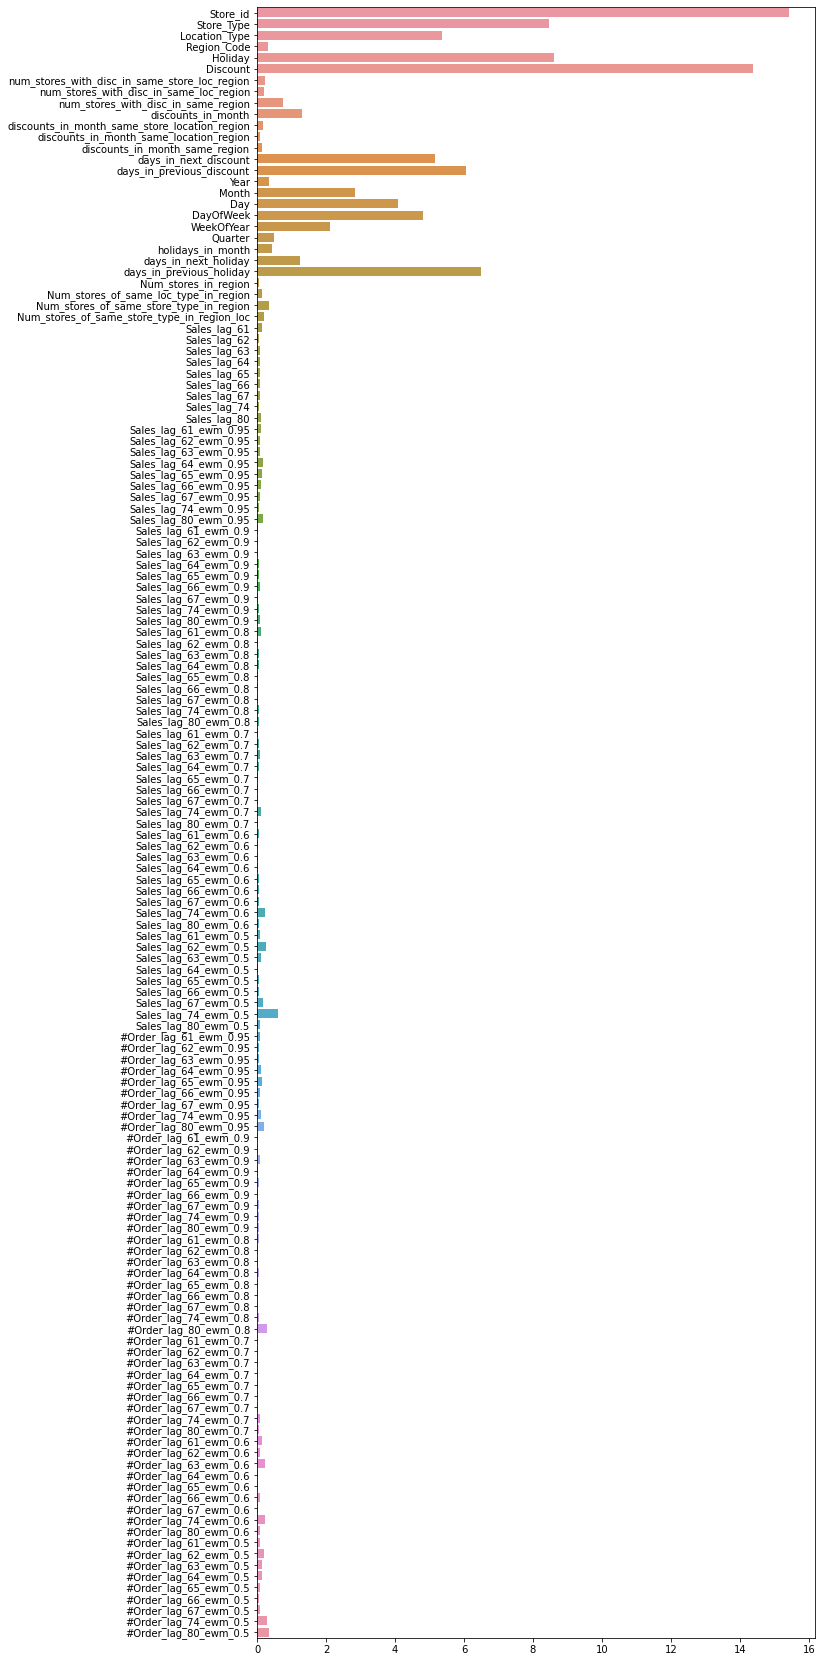

In [163]:
fig, ax = plt.subplots(figsize=(10, 30))
sns.barplot(cat_rg1.feature_importances_, feats, ax=ax)
plt.show()

### Final Model

In [181]:
final_trn_df = trn_df.append(val_df).reset_index(drop=True)

In [182]:
final_trn_df = final_trn_df[final_trn_df['Date'] > '2018-03-01']

In [206]:
cat_rg2 = cb.CatBoostRegressor(iterations=1200, learning_rate=0.08, depth=6, loss_function='RMSE', random_seed=42, l2_leaf_reg=10, od_type='Iter', od_wait=200, use_best_model=True)

In [ ]:
cat_rg2.fit(X=final_trn_df[feats], y=final_trn_df[target], eval_set=val_pool, cat_features=cat_inds, use_best_model=True, verbose=True, plot=False)

In [185]:
1000 * mean_squared_error(np.clip(cat_rg2.predict(val_df[feats]), a_min=0, a_max=None), val_df[target])

18.526852914863706

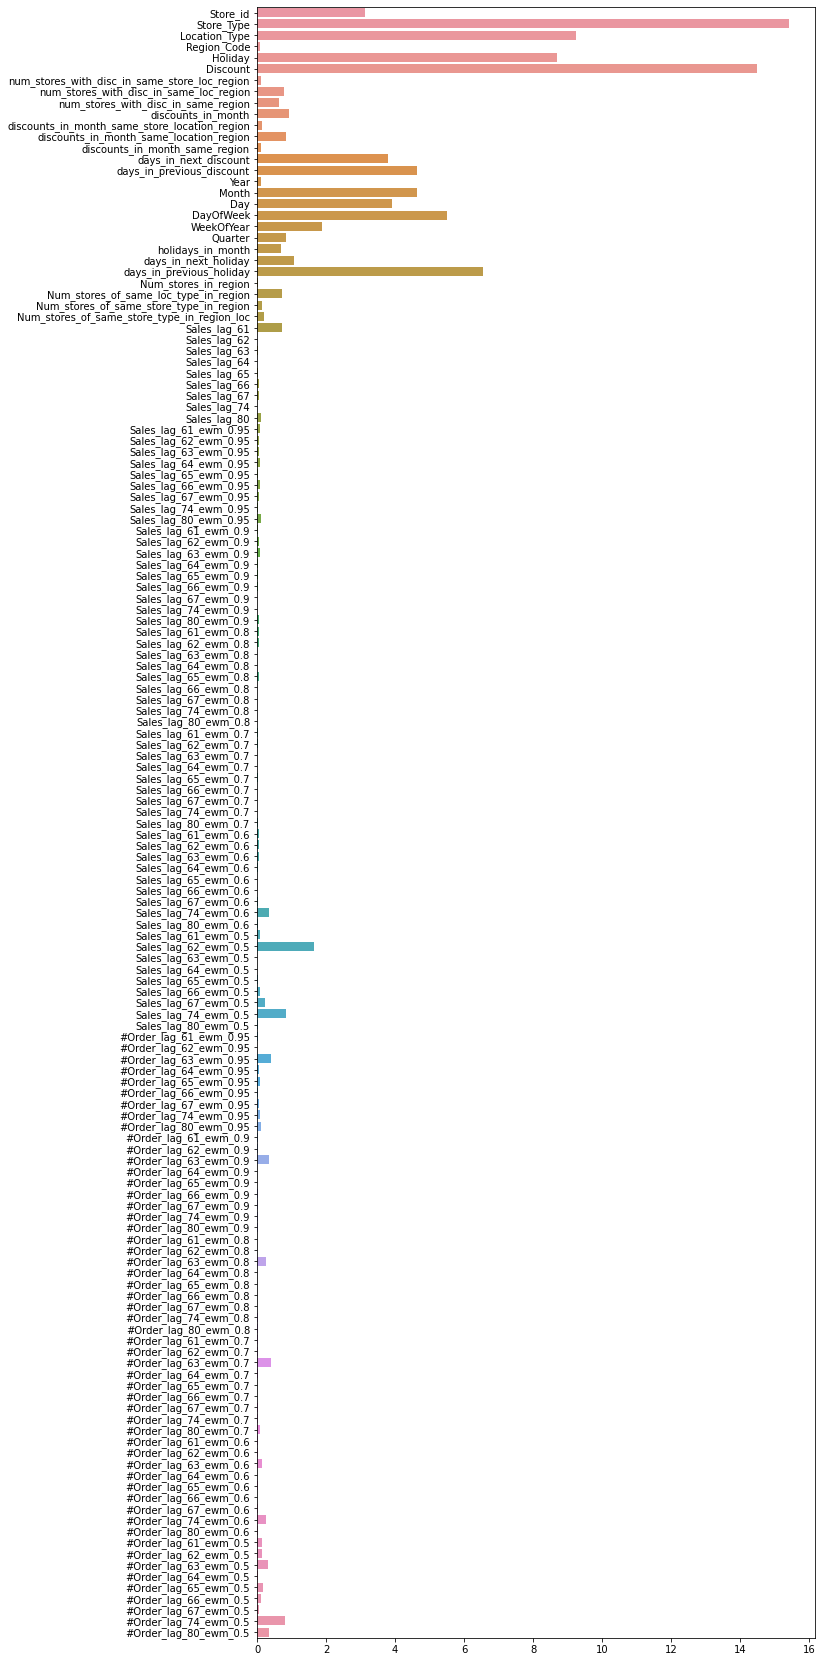

In [194]:
fig, ax = plt.subplots(figsize=(10, 30))
sns.barplot(cat_rg2.feature_importances_, feats, ax=ax)
plt.show()

In [186]:
test_preds = np.clip(cat_rg2.predict(test_df[feats]), a_min=0, a_max=None)

In [190]:
sub_df = test_df[['ID']].copy().reset_index(drop=True)

In [191]:
sub_df['Sales'] = np.exp(test_preds)

In [192]:
sub_df['Sales'].describe()

count     22265.000000
mean      41103.504011
std       14747.906629
min        7261.971886
25%       30667.322859
50%       38497.398502
75%       48715.300840
max      128659.391556
Name: Sales, dtype: float64

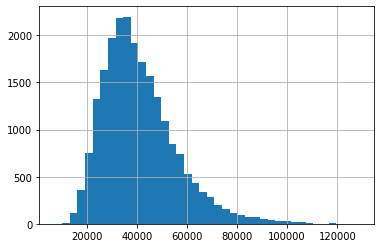

In [193]:
sub_df['Sales'].hist(bins=40)

In [195]:
sub_df.to_csv('sub1.csv', index=False)